In [1]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [3]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_face_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_face_features = num_face_features
    self.fc1 = nn.Linear((self.num_context_features + self.num_face_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context, x_face):
    context_features = x_context.view(-1, self.num_context_features)
    face_features = x_face.view(-1, self.num_face_features)
    fuse_features = torch.cat((context_features, face_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [4]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_face, y_cat, y_cont, transform, context_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.face_norm(self.transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [5]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [6]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''

train_face =  np.stack((np.load(os.path.join(data_src,'pre','train_face_arr.npy')),) * 3, axis=-1)
val_face = np.stack((np.load(os.path.join(data_src,'pre','val_face_arr.npy')),) * 3, axis=-1)
test_face = np.stack((np.load(os.path.join(data_src,'pre','test_face_arr.npy')),) * 3, axis=-1)

#salieny train
train_context = np.load(os.path.join(data_src,'pre', saliency_method + 'train_context_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#salieny val
val_context = np.load(os.path.join(data_src,'pre',saliency_method + 'val_context_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#salieny test
test_context = np.load(os.path.join(data_src,'pre',saliency_method + 'test_context_arr.npy'))

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_face.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_face.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_face.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 48, 48, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 48, 48, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 48, 48, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [7]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

context_norm = [context_mean, context_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_face, train_cat, train_cont, \
                                  train_transform, context_norm, face_norm)
val_dataset = Emotic_PreDataset(val_context, val_face, val_cat, val_cont, \
                                test_transform, context_norm, face_norm)
test_dataset = Emotic_PreDataset(test_context, test_face, test_cat, test_cont, \
                                 test_transform, context_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE EMOTIC MODEL

##Resnet-18 (Places365)

In [8]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2023-07-26 16:40:42--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  48.5MB/s    in 0.9s    

2023-07-26 16:40:43 (48.5 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [9]:
# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [10]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##Resnet-50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-20 21:40:40--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  13.5MB/s    in 8.5s    

2023-07-20 21:40:49 (10.9 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))


## Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

## Face Recognition FER2013 Kaggle

In [11]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [12]:
model_face = Net(1.0)

In [13]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [14]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [15]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [16]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

# VI. Prepare Model + Optimizer

In [17]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [18]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


## FER-2013

In [19]:
def test_data(models, device, data_loader, num_images):
    model_context, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_context = model_context(images_context)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [20]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_face.to(device)

    emotic_model.train()
    model_context.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_context, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_context, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


## FER-2013 Kaggle

In [21]:
def test_data(models, device, data_loader, num_images):
    model_context, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_face = images_face.to(device)

            pred_context = model_context(images_context)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [22]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_face.to(device)

    emotic_model.train()
    model_context.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_context, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_context, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 417206.1003
vad [1.498003  1.9794198 2.0575733] (3,) 1.8449987
epoch = 0 training MAE = 1.8450
epoch = 0 validation loss = 12310.3261
vad [0.8399668  1.0883685  0.89358187] (3,) 0.940639
epoch = 0 val MAE= 0.9406
saving model at epoch e = 0
epoch = 1 training loss = 239638.5539
vad [1.1723773 1.6973974 1.6012348] (3,) 1.4903365
epoch = 1 training MAE = 1.4903
epoch = 1 validation loss = 12480.0800
vad [0.8221899 1.082254  0.8972588] (3,) 0.9339009
epoch = 1 val MAE= 0.9339
epoch = 2 training loss = 226985.4281
vad [1.1408095 1.6645977 1.5540549] (3,) 1.4531541
epoch = 2 training MAE = 1.4532
epoch = 2 validation loss = 10003.8098
vad [0.7868612  0.92104393 0.8792597 ] (3,) 0.8623883
epoch = 2 val MAE= 0.8624
saving model at epoch e = 2
epoch = 3 training loss = 217719.3353
vad [1.1114994 1.6416324 1.5102365] (3,) 1.4211229
epoch = 3 training MAE = 1.4211
epoch = 3 validation loss = 8555.5528
vad [0.7571395  0.84554833 0.8083255 ] (3,) 0.8036711
epoch = 3 val M

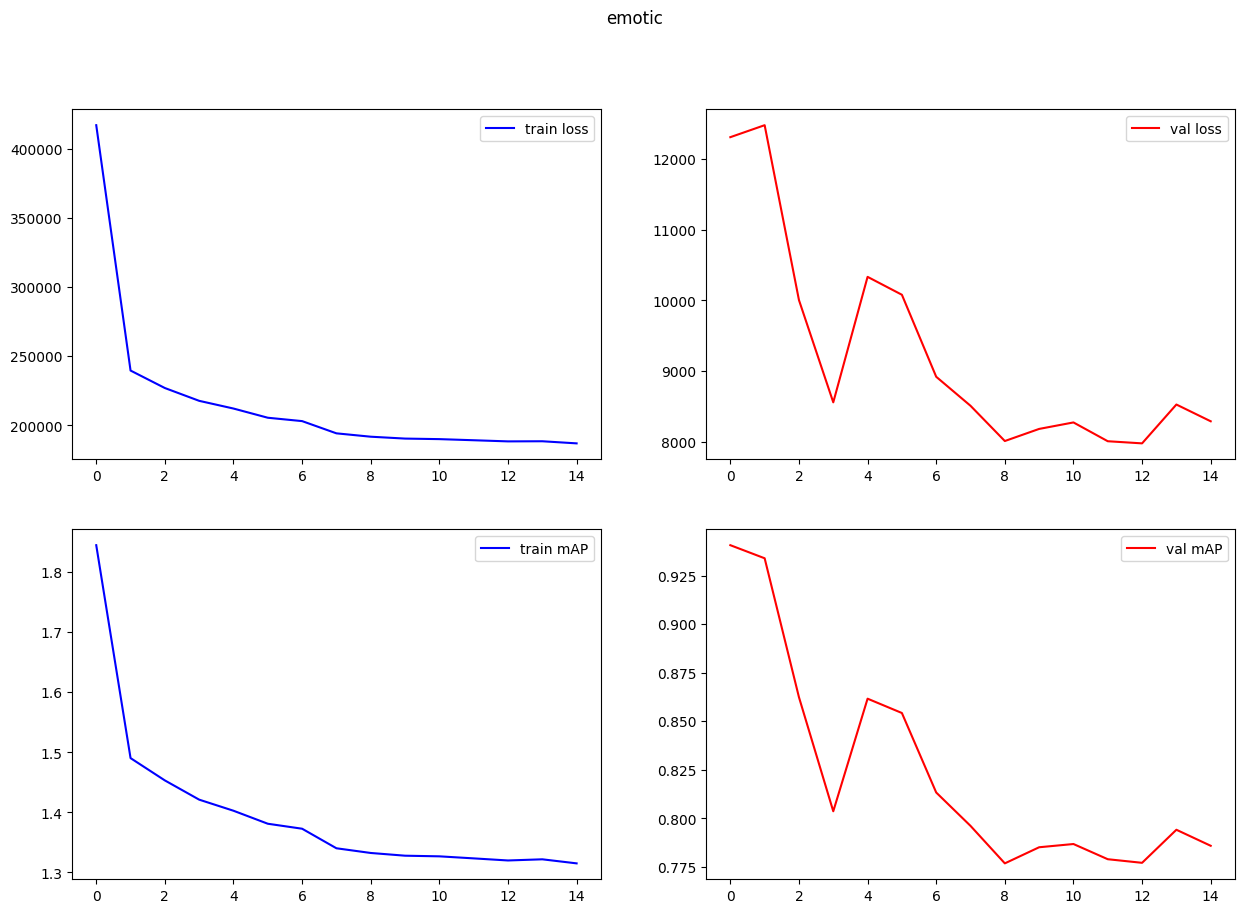

In [23]:
train_emotic(15, './models', opt, scheduler, [model_context, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [24]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
test_vad = test_data([model_context, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.87288904 1.0220202  0.9435135 ] (3,) 0.94614094
0.94614094
testing MAE=0.9461


# Train 2 (resnet18-Fer-2013)

---



##Resnet-18 (Places365)

In [27]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-26 17:20:08--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  49.0MB/s    in 0.9s    

2023-07-26 17:20:09 (49.0 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [28]:
# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [29]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Face Recognition FER2013

In [30]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [31]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [32]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [33]:
model_face = load_trained_model(face_model_path)

In [34]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [35]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [36]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [37]:
model_face_new = Face_Emotion_CNN_new()

In [38]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

# VI. Prepare Model + Optimizer

In [40]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


## FER-2013

In [41]:
def test_data(models, device, data_loader, num_images):
    model_context, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_context = model_context(images_context)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [42]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_face.to(device)

    emotic_model.train()
    model_context.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_context, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_context, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 459310.6279
vad [1.6320186 2.0665386 2.0827737] (3,) 1.9271103
epoch = 0 training MAE = 1.9271
epoch = 0 validation loss = 12918.3921
vad [0.81489635 1.2094173  0.829761  ] (3,) 0.95135826
epoch = 0 val MAE= 0.9514
saving model at epoch e = 0
epoch = 1 training loss = 239290.9117
vad [1.1811283 1.7039409 1.5897021] (3,) 1.4915905
epoch = 1 training MAE = 1.4916
epoch = 1 validation loss = 10267.1788
vad [0.80292326 0.86777794 0.92363745] (3,) 0.86477953
epoch = 1 val MAE= 0.8648
saving model at epoch e = 1
epoch = 2 training loss = 224302.3512
vad [1.1275362 1.6634183 1.5297587] (3,) 1.4402376
epoch = 2 training MAE = 1.4402
epoch = 2 validation loss = 11482.4447
vad [0.84143424 0.98435056 0.89956784] (3,) 0.9084509
epoch = 2 val MAE= 0.9085
epoch = 3 training loss = 217521.2092
vad [1.104692  1.6510683 1.502802 ] (3,) 1.4195207
epoch = 3 training MAE = 1.4195
epoch = 3 validation loss = 8520.9207
vad [0.76881933 0.8490378  0.7879517 ] (3,) 0.8019363
epoch = 3

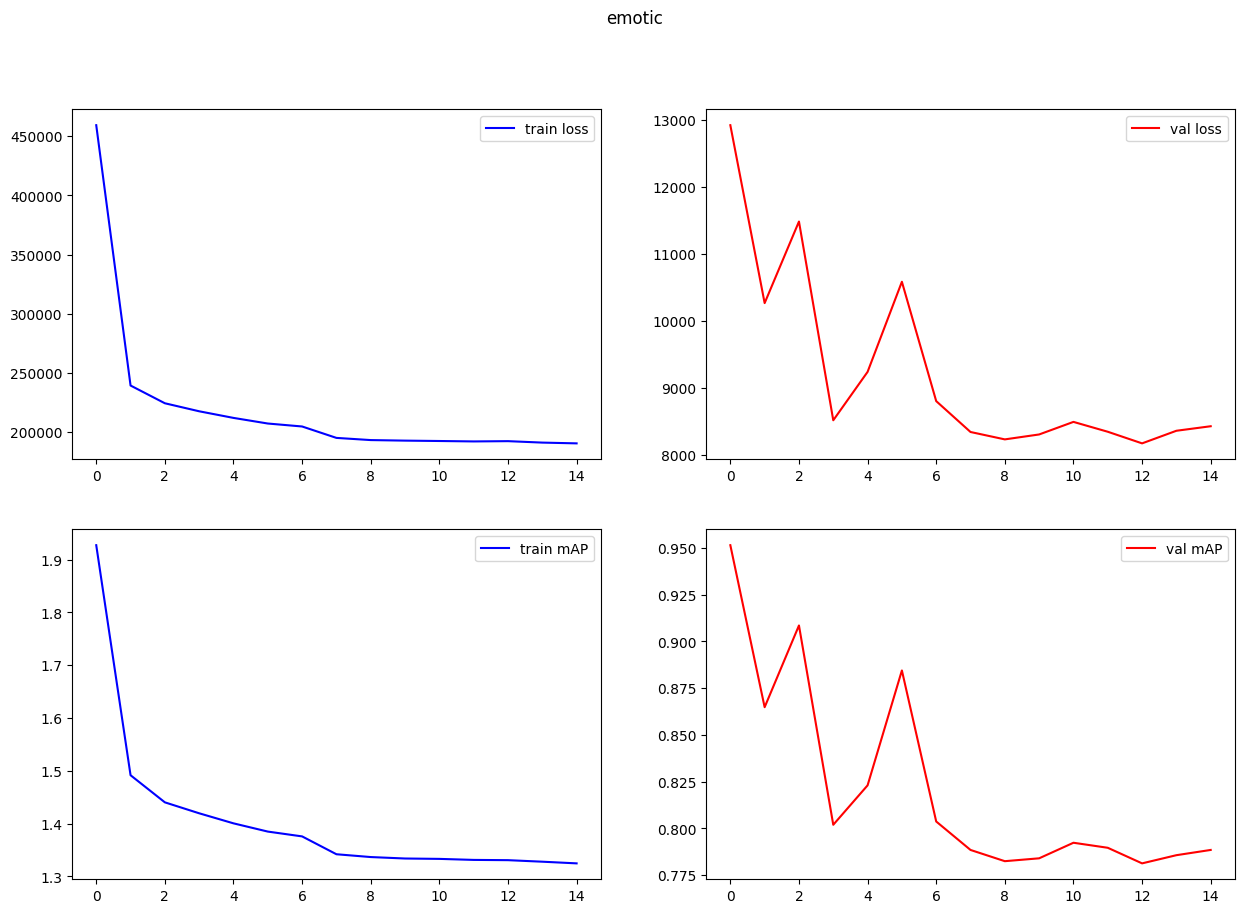

In [43]:
train_emotic(15, './models', opt, scheduler, [model_context, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [44]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
test_vad = test_data([model_context, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.878051   1.0089363  0.93856966] (3,) 0.9418523
0.9418523
testing MAE=0.9419


# **train 3 (Resnet50 - FER-2013)**

---



##Resnet-50 (Places365)

In [47]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-26 17:57:00--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  58.1MB/s    in 1.6s    

2023-07-26 17:57:02 (58.1 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [48]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [49]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Face Recognition FER2013

In [50]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [51]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [52]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [53]:
model_face = load_trained_model(face_model_path)

In [54]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [55]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [56]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [57]:
model_face_new = Face_Emotion_CNN_new()

In [58]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [59]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

# VI. Prepare Model + Optimizer

In [60]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


## FER-2013

In [61]:
def test_data(models, device, data_loader, num_images):
    model_context, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_context = model_context(images_context)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [62]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_face.to(device)

    emotic_model.train()
    model_context.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_context, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_context, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 453406.3791
vad [1.6492558 2.0801978 2.0243835] (3,) 1.9179457
epoch = 0 training MAE = 1.9179
epoch = 0 validation loss = 12548.5937
vad [0.842146   0.95696956 1.0286337 ] (3,) 0.9425831
epoch = 0 val MAE= 0.9426
saving model at epoch e = 0
epoch = 1 training loss = 239281.0011
vad [1.1943347 1.6882952 1.5842578] (3,) 1.4889625
epoch = 1 training MAE = 1.4890
epoch = 1 validation loss = 9695.5602
vad [0.83545405 0.88064134 0.82868737] (3,) 0.84826094
epoch = 1 val MAE= 0.8483
saving model at epoch e = 1
epoch = 2 training loss = 222671.4974
vad [1.1241542 1.661812  1.5251237] (3,) 1.43703
epoch = 2 training MAE = 1.4370
epoch = 2 validation loss = 10069.8605
vad [0.80237496 0.9735292  0.787889  ] (3,) 0.85459775
epoch = 2 val MAE= 0.8546
epoch = 3 training loss = 216052.1067
vad [1.1086116 1.639551  1.5001149] (3,) 1.4160925
epoch = 3 training MAE = 1.4161
epoch = 3 validation loss = 9357.9823
vad [0.7630671  0.84643924 0.8919528 ] (3,) 0.8338197
epoch = 3 va

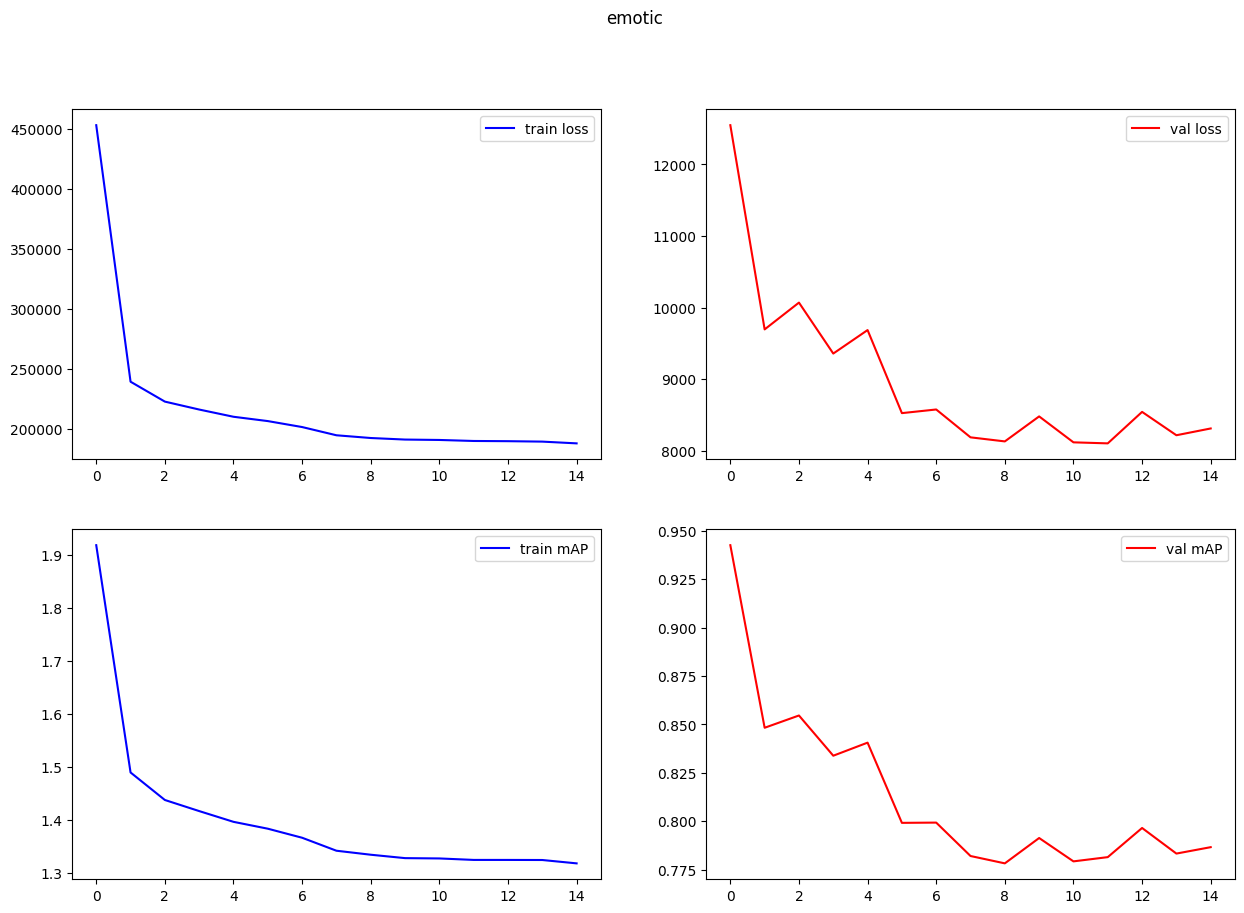

In [63]:
train_emotic(15, './models', opt, scheduler, [model_context, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [64]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [66]:
test_vad = test_data([model_context, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.87459713 1.0227891  0.93297786] (3,) 0.94345474
0.94345474
testing MAE=0.9435


# **Train 4 (resnet50 - FER-Kaggle)**

---



##Resnet-50 (Places365)

In [67]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-26 18:44:05--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  57.8MB/s    in 1.6s    

2023-07-26 18:44:07 (57.8 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [68]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [69]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Face Recognition FER2013 Kaggle

In [70]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [71]:
model_face = Net(1.0)

In [72]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [73]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [74]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [75]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

# VI. Prepare Model + Optimizer

In [76]:
model_face = model_face_new
emotic_model = Emotic(list(model_context.children())[-1].in_features, 256)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


## FER-2013 Kaggle

In [77]:
def test_data(models, device, data_loader, num_images):
    model_context, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_face, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_face = images_face.to(device)

            pred_context = model_context(images_context)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_context, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [78]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_face.to(device)

    emotic_model.train()
    model_context.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, images_face, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_context, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, images_face, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_context, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 444043.3323
vad [1.6916771 2.0014348 1.9823868] (3,) 1.891833
epoch = 0 training MAE = 1.8918
epoch = 0 validation loss = 12492.5624
vad [0.919172  0.9981501 0.9193192] (3,) 0.9455471
epoch = 0 val MAE= 0.9455
saving model at epoch e = 0
epoch = 1 training loss = 237722.7010
vad [1.2006049 1.6841673 1.5809702] (3,) 1.4885808
epoch = 1 training MAE = 1.4886
epoch = 1 validation loss = 13346.4861
vad [0.8593719  0.90199834 1.1209627 ] (3,) 0.9607776
epoch = 1 val MAE= 0.9608
epoch = 2 training loss = 224543.0311
vad [1.1426282 1.6560125 1.5402963] (3,) 1.4463123
epoch = 2 training MAE = 1.4463
epoch = 2 validation loss = 10595.2198
vad [0.7720303  0.87953997 0.96763265] (3,) 0.8730677
epoch = 2 val MAE= 0.8731
saving model at epoch e = 2
epoch = 3 training loss = 217093.1915
vad [1.1233953 1.6379751 1.5024729] (3,) 1.4212812
epoch = 3 training MAE = 1.4213
epoch = 3 validation loss = 8794.0104
vad [0.747788  0.8957099 0.7780538] (3,) 0.8071839
epoch = 3 val MAE=

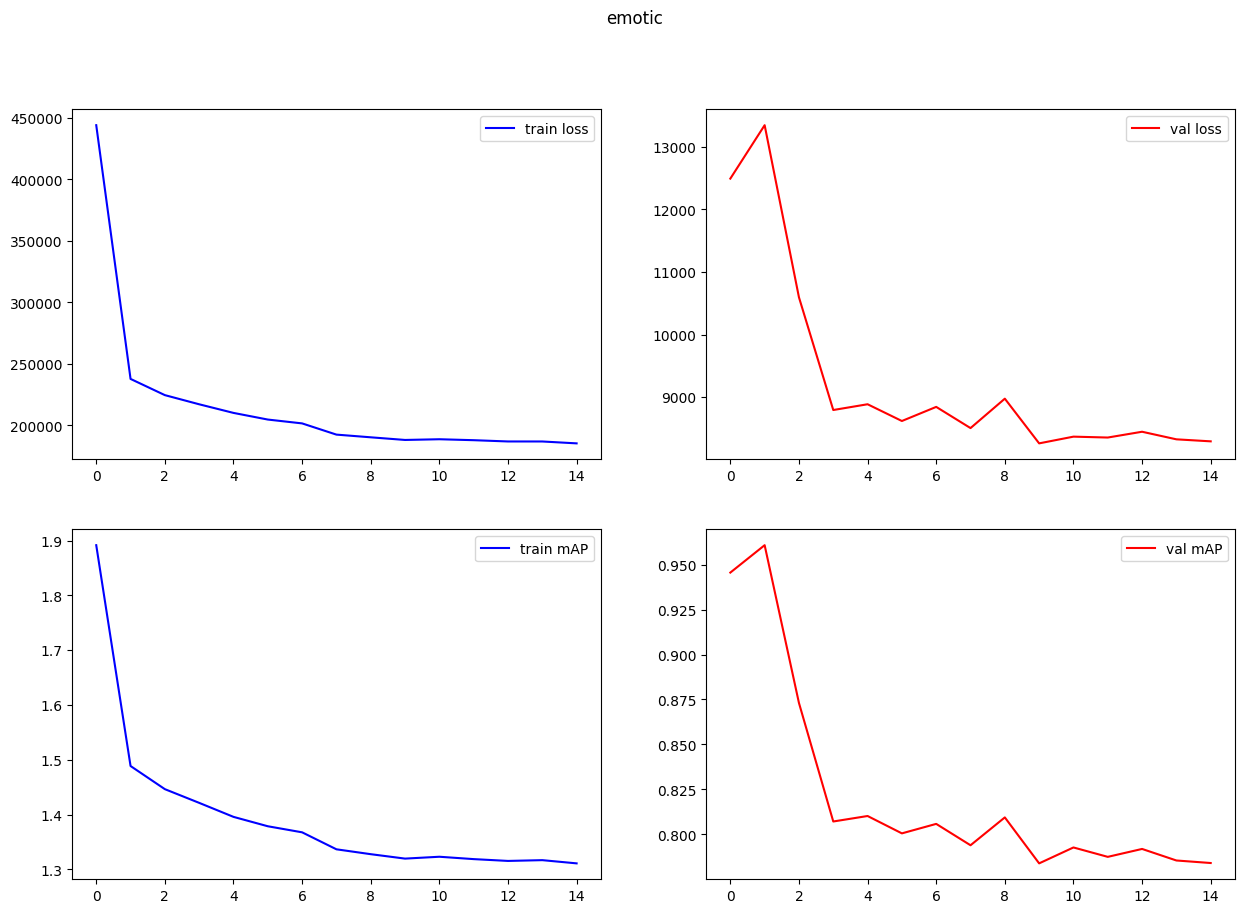

In [79]:
train_emotic(15, './models', opt, scheduler, [model_context, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [80]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
test_vad = test_data([model_context, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.87113804 1.0346738  0.93558127] (3,) 0.947131
0.947131
testing MAE=0.9471
